In [1]:
# Basic Tools
import numpy as np
import pandas as pd
from astropy.table import Table
import matplotlib.pyplot as plt

from scipy.stats import randint, uniform, norm, beta, expon, lognorm, multivariate_normal
from scipy.spatial import distance_matrix
import scipy.integrate as integrate

import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
import plotly.graph_objects as go
import graphviz

import copy
import os

# Notes

- Most stars in clusters have up to 25 element abundances measured, but in some cases there are clusters that have less, down to 21 measured element abundances. So in X[j] I would like, if useful, to have NaNs in the elements that dont have the respective measurement, and then for the statistics just ommit the NaN values.

- There are clusters with 1 star (may consider doing histogram of number of stars)

# Network

## Data

In [2]:
abusolar_cluster_giants = Table.read('data/abusolar_cluster_giants.csv')
abusolar_star_giants_individual_stars = Table.read('data/abusolar_star_giants_individual_stars.csv')

In [3]:
abusolar_cluster_giants.columns

<TableColumns names=('Nstars','cluster','MeanSNR','Na 1','errNa 1','NNa 1','Al 1','errAl 1','NAl 1','Mg 1','errMg 1','NMg 1','Si 1','errSi 1','NSi 1','Ca 1','errCa 1','NCa 1','Sc 2','errSc 2','NSc 2','Ti 1','errTi 1','NTi 1','Ti 2','errTi 2','NTi 2','V 1','errV 1','NV 1','Cr 1','errCr 1','NCr 1','Mn 1','errMn 1','NMn 1','Fe 1','errFe 1','NFe 1','Fe 2','errFe 2','NFe 2','Co 1','errCo 1','NCo 1','Ni 1','errNi 1','NNi 1','Cu 1','errCu 1','NCu 1','Zn 1','errZn 1','NZn 1','Y 2','errY 2','NY 2','Zr 1','errZr 1','NZr 1','Zr 2','errZr 2','NZr 2','Mo 1','errMo 1','NMo 1','Ba 2','errBa 2','NBa 2','Ce 2','errCe 2','NCe 2','Pr 2','errPr 2','NPr 2','Nd 2','errNd 2','NNd 2','oc','ageNN','err_ageNN','age','err_age','dist','X','Y','Z','Rgc','Na1Fe1','errNa1Fe1','Al1Fe1','errAl1Fe1','Mg1Fe1','errMg1Fe1','Si1Fe1','errSi1Fe1','Ca1Fe1','errCa1Fe1','Sc2Fe1','errSc2Fe1','Ti1Fe1','errTi1Fe1','Ti2Fe1','errTi2Fe1','V1Fe1','errV1Fe1','Cr1Fe1','errCr1Fe1','Mn1Fe1','errMn1Fe1','Co1Fe1','errCo1Fe1','Ni1Fe1','errNi

In [4]:
abusolar_cluster_giants = pd.read_csv('data/abusolar_cluster_giants.csv')
abusolar_star_giants_individual_stars = pd.read_csv('data/abusolar_star_giants_individual_stars.csv')

In [5]:
# This because I want to make a function to setup the variables before MCMC, using the Tables as input
cluster_df = abusolar_cluster_giants
clusters_stars_df = abusolar_star_giants_individual_stars

In [6]:
print(cluster_df.columns)
cluster_cols = ['Nstars','cluster','MeanSNR','ageNN','err_ageNN','age','err_age','dist','Rgc','X','Y','Z','ageNN_old','age_old']
cluster_df[cluster_cols]

Index(['Nstars', 'cluster', 'MeanSNR', 'Na 1', 'errNa 1', 'NNa 1', 'Al 1',
       'errAl 1', 'NAl 1', 'Mg 1',
       ...
       'Ba2Fe1', 'errBa2Fe1', 'Ce2Fe1', 'errCe2Fe1', 'Pr2Fe1', 'errPr2Fe1',
       'Nd2Fe1', 'errNd2Fe1', 'ageNN_old', 'age_old'],
      dtype='object', length=136)


,Nstars,cluster,MeanSNR,ageNN,err_ageNN,age,err_age,dist,Rgc,X,Y,Z,ageNN_old,age_old
0,4.0,UBC_3,116.696970,8.301030,0.062,0.200000,0.020635,1644.0,7258.0,1172.0,1145.0,136.0,8.301030,0.200000
1,1.0,NGC_6475,302.000000,8.350000,0.062,0.223872,0.031960,283.0,8057.0,282.0,-20.0,-22.0,8.350000,0.223872
2,12.0,NGC_6705,68.963087,8.480000,0.062,0.301995,0.043113,2164.0,6494.0,1921.0,991.0,-104.0,8.480000,0.301995
3,5.0,NGC_3532,176.800000,8.600000,0.048,0.398107,0.044000,498.0,8186.0,166.0,-469.0,12.0,8.600000,0.398107
4,1.0,Stock_1,211.000000,8.640000,0.048,0.436516,0.048246,410.0,8144.0,203.0,356.0,14.0,8.640000,0.436516
5,5.0,UBC_215,71.800000,8.650000,0.048,0.446684,0.049369,1372.0,9474.0,-1099.0,-814.0,-107.0,8.650000,0.446684
6,10.0,NGC_2099,69.350000,8.650000,0.048,0.446684,0.049369,1384.0,9721.0,-1380.0,56.0,74.0,8.650000,0.446684
7,2.0,NGC_6281,135.000000,8.710000,0.048,0.512861,0.056684,532.0,7820.0,520.0,-112.0,18.0,8.710000,0.512861
8,3.0,NGC_6645,74.333333,8.710000,0.048,0.512861,0.056684,1750.0,6675.0,1680.0,474.0,-110.0,8.710000,0.512861
9,2.0,FSR_0850,67.191489,8.710000,0.048,0.512861,0.056684,2126.0,10462.0,-2121.0,-130.0,-85.0,8.710000,0.512861


In [7]:
print(clusters_stars_df.columns)
star_cols = ['Unnamed: 0','cluster','star','element','synth_MH','synth_MH_err',
             'synth_x_over_h','synth_x_over_h_err','synth_absolute_abund','synth_absolute_abund_err']
clusters_stars_df[star_cols]

Index(['Unnamed: 0', 'cluster', 'star', 'element', 'synth_teff',
       'synth_teff_err', 'synth_logg', 'synth_logg_err', 'synth_MH',
       'synth_MH_err', 'synth_vmic', 'synth_vmic_err', 'synth_vmac',
       'synth_vmac_err', 'synth_vsini', 'synth_vsini_err', 'synth_R',
       'synth_R_err', 'vel_atomic', 'vel_atomic_err', 'synth_x_over_h',
       'synth_x_over_h_err', 'synth_absolute_abund',
       'synth_absolute_abund_err', 'synth_nlines', 'snr'],
      dtype='object')


,Unnamed: 0,cluster,star,element,synth_MH,synth_MH_err,synth_x_over_h,synth_x_over_h_err,synth_absolute_abund,synth_absolute_abund_err
0,25,FSR_0278,G2180302768725634688,Al 1,-0.11,0.03,0.059541,0.0142,6.5259,0.0127
1,26,FSR_0278,G2180302768725634688,Ba 2,-0.11,0.03,0.076139,0.0163,2.1975,0.0064
2,27,FSR_0278,G2180302768725634688,Ca 1,-0.11,0.03,0.029721,0.0327,6.3626,0.0866
3,28,FSR_0278,G2180302768725634688,Co 1,-0.11,0.03,0.023984,0.0397,4.9239,0.1103
4,29,FSR_0278,G2180302768725634688,Cr 1,-0.11,0.03,-0.010506,0.0941,5.6099,0.0788
...,...,...,...,...,...,...,...,...,...,...
5193,6235,UBC_6,G1989397554090593920,V 1,-0.18,0.03,-0.115689,0.0181,3.7584,0.0641
5194,6236,UBC_6,G1989397554090593920,Y 2,-0.18,0.03,0.048903,0.0050,2.2095,0.0411
5195,6237,UBC_6,G1989397554090593920,Zn 1,-0.18,0.03,-0.057484,0.1162,4.2618,0.1144
5196,6238,UBC_6,G1989397554090593920,Zr 1,-0.18,0.03,-0.156725,0.2482,2.5163,0.2468


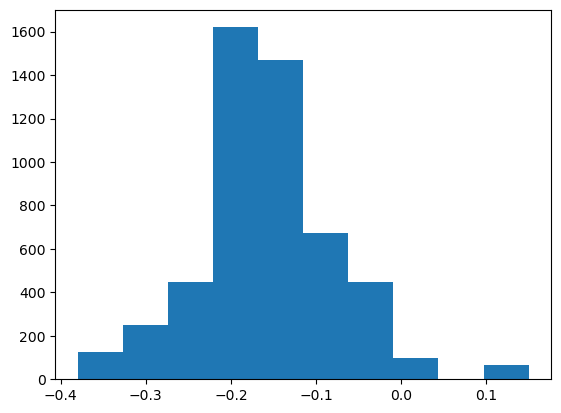

In [8]:
# See the distribution of metallicities of stars in the different clusters
plt.hist(clusters_stars_df['synth_MH']);

# Indexation dictionaries

In [9]:
z_elements = [11,12,13,14,20,21,22,23,24,25,26,27,28,29,30] # Future input of the atomic number of elements we want to use
z_to_idx = {z: i for i, z in enumerate(z_elements)}
idx_to_z = {value:key for (key,value) in z_to_idx.items()}

In [10]:
z_to_str = {
    1: 'Hydrogen',
    2: 'Helium',
    6: 'Carbon',
    7: 'Nitrogen', 
    8: 'Oxygen',
    9: 'Fluorine',
    10: 'Neon',
    11: 'Sodium',
    12: 'Magnesium',
    13: 'Aluminum',
    14: 'Silicon',   
    15: 'Phosphorus',   
    16: 'Sulphur',
    17: 'Chlorine',
    18: 'Argon',
    19: 'Potassium',
    20: 'Calcium',
    21: 'Scandium', 
    22: 'Titanium',
    23: 'Vanadium',
    24: 'Chromium',
    25: 'Manganese',
    26: 'Iron',
    27: 'Cobalt',
    28: 'Nickel',
    29: 'Copper',
    30: 'Zinc',
    39: 'Yttrium', # From here not available in Yields
    40: 'Zirconium',
    42: 'Molybdenum',
    56: 'Barium',
    58: 'Cerium',
    59: 'Praseodynium',
    60: 'Neodynium'}
str_to_z = {value:key for (key,value) in z_to_str.items()}

In [11]:
z_to_df = {
    11: 'Na 1',
    12: 'Mg 1',
    13: 'Al 1',
    14: 'Si 1',
    20: 'Ca 1',
    21: 'Sc 2', 
    22: 'Ti 2', # More reliable, same measurements (~11) 
    23: 'V 1',
    24: 'Cr 1',
    25: 'Mn 1',
    26: 'Fe 1', # Most measurements (90-100) vs Fe 2 (<10)
    27: 'Co 1',
    28: 'Ni 1',
    29: 'Cu 1',
    30: 'Zn 1',
    39: 'Y 2',
    40: 'Zr 1', # Dont know which one is more reliable, same measurementes (~1)
    42: 'Mo 1',
    56: 'Ba 2',
    58: 'Ce 2',
    59: 'Pr 2',
    60: 'Nd 2',
    }
df_to_z = {value:key for (key,value) in z_to_df.items()}

In [12]:
z_weights = {
    1: 1.008,
    2: 4.003,
    3: 6.941,
    4: 9.012,
    5: 10.811,
    6: 12.011,
    7: 14.007,
    8: 15.994,
    9: 18.998,
    10: 20.179,
    11: 22.990,
    12: 24.305,
    13: 26.982,
    14: 28.086,
    15: 30.974,
    16: 32.060,
    17: 35.450,
    18: 39.950,
    19: 39.100,
    20: 40.080,
    21: 44.960,
    22: 47.900,
    23: 50.941,
    24: 51.996,
    25: 54.938,
    26: 55.847,
    27: 58.933,
    28: 58.710,
    29: 63.646,
    30: 65.370
}
z_ratio = {z: weight/z_weights[1] for z, weight in z_weights.items()}

In [13]:
# To see if the mapping is correct
for j, z in enumerate(z_elements):
    print(j, z, z_to_str[z], z_to_df[z], z_ratio[z])

0 11 Sodium Na 1 22.80753968253968
1 12 Magnesium Mg 1 24.112103174603174
2 13 Aluminum Al 1 26.767857142857142
3 14 Silicon Si 1 27.863095238095237
4 20 Calcium Ca 1 39.76190476190476
5 21 Scandium Sc 2 44.6031746031746
6 22 Titanium Ti 2 47.519841269841265
7 23 Vanadium V 1 50.53670634920635
8 24 Chromium Cr 1 51.583333333333336
9 25 Manganese Mn 1 54.50198412698413
10 26 Iron Fe 1 55.40376984126984
11 27 Cobalt Co 1 58.46527777777778
12 28 Nickel Ni 1 58.24404761904762
13 29 Copper Cu 1 63.14087301587302
14 30 Zinc Zn 1 64.85119047619048


# Setting T and X

In [14]:
'''# Without element selection
clusters = np.array(cluster_df['cluster']) # Cluster names
K = len(clusters) # Number of clusters

# Setting T (and R, for later A_m)
T_m, T_sd = np.array(cluster_df['age']), np.array(cluster_df['err_age'])
cluster_R = np.array(cluster_df['Rgc']).reshape(-1,1) # Is Rgc the radius in pc? If not, where to find cluster radius

# We reorder the arrays based on cluster Age T_m from oldest to youngest
cluster_sort_idx = np.argsort(T_m)[::-1]
clusters = clusters[cluster_sort_idx]
T_m, T_sd = T_m[cluster_sort_idx], T_sd[cluster_sort_idx]

# Setting X
# Approach in case I want to keep all the elements and set as NaN for the stars with missing ones.
X = [] # List with matrices X[k] k=1,...,K of shape N_cluster_stars x N_elements
elements = np.unique(clusters_stars_df['element']) # All the available element abundances (in order)
element_idx = lambda element: np.where(elements == element)[0][0] # Mapping for element to idx in ordered array
for k, cluster in enumerate(clusters):
    cluster_mask = clusters_stars_df['cluster'] == cluster
    cluster_individual_stars = clusters_stars_df[cluster_mask]
    cluster_stars = np.unique(cluster_individual_stars['star'])
    star_elements = np.unique(cluster_individual_stars['element'])
    Xk = np.full((len(cluster_stars), len(elements)), np.nan) # Empty matrix
    for i, star in enumerate(cluster_stars):
        star_mask = cluster_individual_stars['star'] == star
        individual_star = cluster_individual_stars[star_mask]       
        elements_idx = list(individual_star['element'].apply(element_idx)) # Map the available elements to their respective ordered index
        Xk[i,elements_idx] = individual_star['synth_x_over_h'] # 'synth_x_over_h', 'synth_absolute_abund'
    X.append(Xk)''';

In [15]:
# With element selection
clusters = np.array(cluster_df['cluster']) # Cluster names
K = len(clusters) # Number of clusters

# Setting T (and R, for later A_m)
T_m, T_sd = np.array(cluster_df['age']), np.array(cluster_df['err_age'])
cluster_Rgc = np.array(cluster_df['Rgc']).reshape(-1,1) # Galactocentric radius
Delta_Rgc = distance_matrix(cluster_Rgc, cluster_Rgc, p=1)

# We reorder the arrays based on cluster Age T_m from oldest to youngest
cluster_sort_idx = np.argsort(T_m)[::-1]
clusters = clusters[cluster_sort_idx]
T_m, T_sd = T_m[cluster_sort_idx], T_sd[cluster_sort_idx]

# Setting X
X = [] # List with matrices X[k] k=1,...,K of shape (# cluster k stars) x (# elements)
for k, cluster in enumerate(clusters):
    cluster_mask = clusters_stars_df['cluster'] == cluster
    cluster_individual_stars = clusters_stars_df[cluster_mask]
    cluster_stars = np.unique(cluster_individual_stars['star'])
    star_elements = np.unique(cluster_individual_stars['element'])
    Xk = np.full((len(cluster_stars), len(z_elements)), np.nan) # Empty matrix
    for i, star in enumerate(cluster_stars):
        star_mask = cluster_individual_stars['star'] == star
        individual_star = cluster_individual_stars[star_mask]
        individual_star_abundances = np.array(individual_star['synth_absolute_abund'])
        for l, element in enumerate(individual_star['element']): # l to index element
            try:
                z = df_to_z[element]
                j = z_to_idx[z] # We recover the index j for the element in the df
                Xk[i,j] = 10**(individual_star_abundances[l] - 12) * z_ratio[z] #* 0.7
            except:
                continue
    X.append(Xk)

In [16]:
len(X)

47

In [17]:
# Filling missing values for clusters with 2+ stars and removing clusters of 1 star with missing values
# obs: by doing this I lose 1 cluster
cluster_mask = np.ones(len(clusters), dtype='bool')
cluster_exclude_idx = []
X_ = []
for k, cluster in enumerate(clusters):
    exclude = False
    for i in range(len(X[k])):
        missing_element_idx = np.argwhere(np.isnan(X[k][i]))
        if (len(missing_element_idx)>0): # If star i has a missing value for one of the species
            if (len(X[k])>1): # If there are other stars in cluster k, we fill with the mean value over the other stars in the cluster
                print('Filling missing value for star {} in cluster {}: {}.'.format(i,k,cluster))
                X[k][i,missing_element_idx] = np.nanmean(X[k][:,missing_element_idx] , axis=0)
            else: # If there is only one star, we delete the cluster
                print('Removed cluster {}: {}'.format(k,cluster))
                exclude = True
                cluster_exclude_idx.append(k)
                
    if exclude: 
        continue # We skip the cluster to remove
    else:
        X_.append(X[k])

# Change arrays after removing the clusters
X = X_
cluster_mask[cluster_exclude_idx] = 0
clusters = clusters[cluster_mask]
K = len(clusters)
T_m, T_sd = T_m[cluster_mask], T_sd[cluster_mask]
cluster_Rgc = cluster_Rgc[cluster_mask]
Delta_Rgc = distance_matrix(cluster_Rgc, cluster_Rgc, p=1)

Filling missing value for star 2 in cluster 0: NGC_6791.
Filling missing value for star 1 in cluster 6: King_1.
Removed cluster 22: UBC_44
Filling missing value for star 0 in cluster 37: FSR_0850.


In [18]:
len(X)

46

# CalY

In [19]:
# Initial Mass Function IMF
def chabrier_IMF(M,M_c=0.079,s=0.69,A_phi=0.842984,B_phi=0.235480):
    assert (M>=0.1) & (M<=120), 'Mass should be in range [0,1,120]'
    return A_phi * M**(-1) * np.exp(-(np.log(M)-np.log(M_c))**2/(2*s**2)) if M <= 1 else B_phi * M**(-2.3)

chabrier_IMG_vfunc = np.vectorize(chabrier_IMF) # Vectorized function to apply to arrays

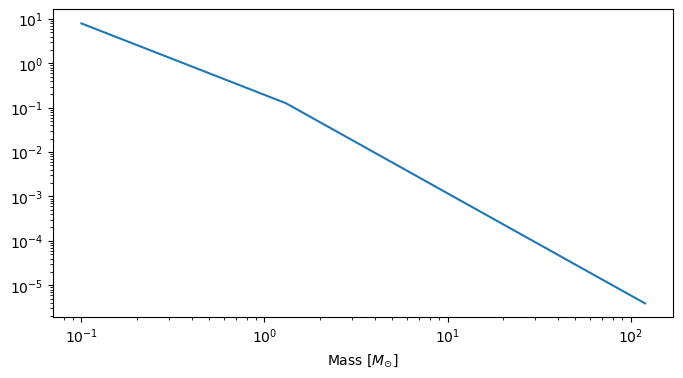

In [20]:
Ms = np.linspace(0.1,120,100)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,4))
ax.plot(Ms,chabrier_IMG_vfunc(Ms))
ax.set_xlabel(r'Mass [$M_{\odot}$]')
#ax.set_ylabel(r'Mass fraction')
ax.set_xscale('log')
ax.set_yscale('log')

In [21]:
def PL_DTD(t,T,dt,a=0.15242, tmin=0.0035):
    #Already integrated expresion of the DTD between (T-t) and (T-t) + dt
    return a * (-1/0.12) * (((T-t)+dt)**(-0.12) - (T-t)**(-0.12)) if (T-t) >= tmin else 0

'''
def PL_DTD(tau,a=0.15242):
    return a / (tau)**1.12
''';

In [22]:
IMF_dict = {'chabrier': chabrier_IMF}
DTD_dict = {'power law': PL_DTD}

In [23]:
AGB_y_004 = pd.read_csv("/home/kwalsen/Documents/ERIS/networks/data/yields/AGB_004.csv") # Interpolated to include bin 6-7
AGB_y_02 = pd.read_csv("/home/kwalsen/Documents/ERIS/networks/data/yields/AGB_02.csv") # Interpolated to include bin 6-7
SNII_y_004 = pd.read_csv("/home/kwalsen/Documents/ERIS/networks/data/yields/SNII_004.csv")
SNII_y_02 = pd.read_csv("/home/kwalsen/Documents/ERIS/networks/data/yields/SNII_02.csv")
SNIa_y = pd.read_csv("/home/kwalsen/Documents/ERIS/networks/data/yields/SNIa.csv")
Yields_dict = {'AGB_004': AGB_y_004,
               'AGB_02': AGB_y_004,
               'SNII_004': SNII_y_004,
               'SNII_02': SNII_y_02,
               'SNIa': SNIa_y}

In [24]:
def calY(t,T,dt,G,Xk,
         A=0.028,
         IMF='chabrier', DTD='power law',
         IMF_dict = IMF_dict, DTD_dict = DTD_dict, Yields_dict = Yields_dict):
    '''
    dt:
    tmin: Minimum delay time tmin=35Myr=0.0035Gyr
    Xk of shape I x J
    
    Returns:
    
    Y_m: Median of normal distribution
    Y_sd: Standard deviation of normal distribution
    
    '''
    
    I, J = np.shape(Xk)
    
    # Masses
    AGB_m = np.array([0.85,0.918,0.992,1.071,1.154,1.239,1.315,1.407,1.499,1.583,1.667,1.75,1.832,1.85,1.9,2,2.2,2.5,3,3.5,4,4.5,5,6])
    SNII_m = np.array([7,9,12,15,20,30,40,60,100,120]) # add 8?
    m = np.hstack([AGB_m, SNII_m]) # Array of all mass bins (except SNIa)
    
    ## Treat the lifetimes here?
    LT = pd.read_csv("/home/kwalsen/Documents/ERIS/networks/data/yields/lifetime.csv") 
    a0, a1, a2 = np.polyfit(x=np.log10(np.tile(LT['mass'],6)),
                            y=np.log10(np.transpose(np.array(LT)[:,1:]).flatten()),
                            deg=2)[::-1]
    fit = lambda x: a0 + a1*x + a2 * x**2
    AGB_t = fit(np.log10(AGB_m))
    SNII_t = fit(np.log10(SNII_m))
    
    # Number of stars per mass bin
    p_m = np.array([integrate.quad(func=IMF_dict[IMF], a=m[i], b=m[i+1])[0] for i in range(len(m)-1)]) # Cumulative of IMF for the mass bin m
    
    # We drop the last value since in the counts we sum over all the bin, indexing with the lower bound
    m = m[:-1]
    SNII_t = SNII_t[:-1] # Since we drop m=120
    
    # Counts per mass bin in cluster of gas mass G
    n_m = G*(p_m/m) # Expected total number of stars of mass bin m
    #n_m = norm.rvs(loc=G*(p/m[:-1]), scale=G*(p/m[:-1])) # May contain negative values since the high scale
    
    # Define A' for w_m
    P316 = np.sum(p_m[np.where((m>3)*(m<16))]) # Sum of pdf in-between bins (relies on grid m), != 0.0385 (Yates et Al. 2013) 
    A_prime = A*P316 # A' 
    
    AGB_n_m = n_m[(m>=0.85)*(m<=6)]#.reshape(-1,1) # 0.85:7
    SNIa_n_m = np.array([A_prime*np.sum(n_m[(m>=0.85)*(m<=7)])]) # 0.85:9 (Don't have 8 in SNII tables)
    SNII_n_m = np.hstack([(1-A)*n_m[(m>=7)&(m<=16)],n_m[(m>16)]])#.reshape(-1,1) # 7:16, >16:
    
    # Define w_m for Y_m
    def w_m(t,T,dt,Xki):
        '''
        I want it to return a matrix of shape [len(m),J] where J is the number of species sampled for stars in cluster k  
        Input:
        t,T,tau,
        Xki=X[k][i] matrix of star i's abundances in cluster k,
        n_m = dict of star counts for each mass bin m of different yield processes
        
        '''
        J = len(Xki)
        
        # Yields
        SNIa_y = Yields_dict['SNIa']
        if np.sum(Xki) < 0.02: # Metallicity of star i in cluster k
            AGB_y = Yields_dict['AGB_004']
            SNII_y = Yields_dict['SNII_004'][1:-1] # Since we drop m=6,120 in this case
        else:
            AGB_y = Yields_dict['AGB_02']
            SNII_y = Yields_dict['SNII_02'][1:-1] # Since we drop m=6,120 in this case
        
        # Arrays with yields for J species
        AGB_w = np.zeros((len(AGB_y),J))
        SNIa_w = np.zeros(J)
        SNII_w = np.zeros((len(SNII_y),J))
        for j, z in enumerate(z_elements): # For each species, j -> element need a mapping maybe
            element = z_to_str[z] # Convert the element z to the column in the Yields
            if element in AGB_y.columns:
                AGB_w[:,j] = ((Xki[j] * AGB_y['total_ejected'] + AGB_y[element]) * ((AGB_t >= ((T-t) - dt)) * (AGB_t < ((T-t) + dt)))) # 0.85 < m <= 7 
            if element in SNIa_y.columns:
                SNIa_w[j] = (Xki[j] * SNIa_y['Total_metal'] + SNIa_y[element]) * DTD_dict[DTD](t,T,dt) # 0.85 < m <= 8
                #SNIa_w[j] = (Xki[j] * SNIa_y['Total_metal'] + SNIa_y[element]) * integrate.quad(DTD_dict[DTD], a=(T-t), b=(T-t) + dt)[0] # 0.85 < m <= 8
            if element in SNII_y.columns:
                SNII_w[:,j] = (Xki[j] * SNII_y['total_ejected'] + SNII_y[element]) * ((SNII_t >= ((T-t) - dt)) * (SNII_t < ((T-t) + dt))) # 7 < m <= 16; m>16
        
        Wm = {'AGB': AGB_w, 'SNIa': SNIa_w, 'SNII': SNII_w}
            
        return Wm
    
    # Define omega_m for Y_sd
    def omega_m(Wm,n_m):
        '''
        Returns
        
        (JxJ) matrix
        '''
        out = np.dot(np.dot(np.transpose(Wm), np.diag(n_m)), Wm) # ((JxM)x(MxM))x(MxJ)
        
        return out
    
    Y_m = np.zeros(J) # Mean of total mass yields
    Y_sd = np.zeros((J,J)) # Standard deviation of total mass yields
    for i in range(I): # Each star in cluster k
        Xki = Xk[i] # Vector with species abundances of star i
        # Get the yields based in the abundances of star i
        Wm = w_m(t,T,dt,Xki) 
        AGB_w = Wm['AGB']
        SNIa_w = Wm['SNIa']
        SNII_w = Wm['SNII']
        
        Y_m += np.sum(AGB_n_m.reshape(-1,1) * AGB_w, axis=0) + SNIa_n_m * SNIa_w + np.sum(SNII_n_m.reshape(-1,1) * SNII_w, axis=0)
        Y_sd = omega_m(AGB_w, AGB_n_m) + omega_m(SNIa_w.reshape(1,-1), SNIa_n_m) + omega_m(SNII_w, SNII_n_m)
                
    Y_m = Y_m / I 
    Y_sd = Y_sd / I**2

    return Y_m, Y_sd

# Setting prior for T, G, A

In [25]:
# If priors are set as arrays
#print('Pr_T')
#Pr_T = norm.rvs(loc=T_m, scale=T_sd, size=K)
#print(Pr_T)

print('Pr_G')
G_m, G_sd = 1e5, 1e5 # Don't know the actual values yet, set it to get a range of values of order 1e5
s = 1 # Shape parameter for distribution, don't know actual useful value for this yet
N = 10 # Bins of equal probability, don't know if N=K or a value sufficiently high
G_bins = randint.rvs(low=1, high=N+1, loc=0, size=K)
Pr_G = lognorm.ppf(q=(G_bins-0.5)/N, s=s, loc=G_m, scale=G_sd)
print(Pr_G)

#print('Pr_A')
#'''
#A_m = distance_matrix(cluster_R, cluster_R, p=1)
#A_m = np.where(A_m!=0, 1/A_m,0) # Find a better way to compute it and avoid warning
#Pr_A = expon.rvs(loc=0, scale=A_m, size=(K,K))
#''';
#f = np.vectorize(lambda b: beta.rvs(a=1,b=b))
#Pr_A = np.triu(f(Beta),k=1)
#print(Pr_A)

Pr_G
[188191.3458984  119304.08166987 381914.42726747 119304.08166987
 381914.42726747 168023.26095706 135471.75679133 618025.1602233
 119304.08166987 168023.26095706 213389.81050953 618025.1602233
 168023.26095706 119304.08166987 135471.75679133 296303.10841583
 213389.81050953 150941.62838633 296303.10841583 135471.75679133
 150941.62838633 119304.08166987 213389.81050953 188191.3458984
 247008.53589351 247008.53589351 247008.53589351 381914.42726747
 213389.81050953 381914.42726747 119304.08166987 168023.26095706
 135471.75679133 381914.42726747 618025.1602233  213389.81050953
 247008.53589351 618025.1602233  381914.42726747 150941.62838633
 119304.08166987 296303.10841583 618025.1602233  618025.1602233
 188191.3458984  119304.08166987]


# Initialization

In [26]:
# If the priors were set as arrays
T = T_m 
G = Pr_G

dt = 2 # Which value of dt is reasonable? also for G_m, G_sd for G
J = np.shape(X[0])[1] # Number of species

# Get Y_m
Y_m = np.zeros((K,K,J)) # I use only half of the arrays, should optimize space if necessary
Y_sd = np.zeros((K,K,J,J))
for l in np.arange(len(X)):
    for k in range(l+1,len(X)):
        Y_m[l,k,:], Y_sd[l,k,:,:] = calY(T[k], T[l], dt, G[l], X[l])
print(Y_m.shape)
print(Y_sd.shape)

# Dummy A for testing stuff, may remove later
A_ = 0.5 * np.vstack([np.array([np.concatenate([np.zeros(k),1/(K-k)*np.ones(K-k)]) for k in range(1,K)]),
          np.zeros(K)]) # Assuming all cluster equally contribute half its gas to younger clusters

# Initialization of A
A = np.zeros((K,K))
for k in range(1,len(X)): # A[0,0] = 0
    A[:k,k] = np.linalg.pinv(np.dot(Y_m[:k,k], np.mean(X[k], axis=0)).reshape(-1,1))

# May remove, this guarantees values of A between 0 and 1, dont know the relation with Rgc in the initialization
for k in range(len(X)): # May be necessary so I dont get -inf in logPr for A
    A[k,:] = A[k,:] / G[k] #

A = A - A*(A<0) # We subtract the negative values out of A
#A[np.where(A>1)] = 1 # 2% of entries are greater than 1
print(A.shape)
print(np.min(A[A>0]), np.max(A))
print(A[:4,:4])

(46, 46, 15)
(46, 46, 15, 15)
(46, 46)
1.8441693792383293e-07 0.004002013436186032
[[0.00000000e+00 1.51467717e-03 3.13681659e-03 2.90934903e-04]
 [0.00000000e+00 0.00000000e+00 4.00201344e-03 9.13883967e-05]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 2.65582913e-04]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]]


In [27]:
# logLik and logPr
def logLikelihood(T,G,X,Y_m,Y_sd,A):
    '''
    '''
    out = 0
    for k in range(1,len(X)): # For each cluster k (excluding the first one: to be pristine gas)
        mean = np.sum(A[:k,k].reshape(-1,1) / G[k] * Y_m[:k,k], axis=0) 
        cov = np.sum((A[:k,k] / G[k])**2 * np.transpose(Y_sd[:k,k], axes=[1,2,0]), axis=2) # each term shape (J,J,#{l: T[l]>T[k]})
        
        # To avoid truncation errors for floating point numbers 
        #cov = np.triu(cov, k=1) + np.triu(cov,k=1).T + np.diag(np.diag(cov)) # Force floating point symmetry (not necesary)
        cov[np.where((cov - cov.T != 0) & ((cov < np.finfo(cov.dtype).eps) & (cov > 0)))] = 0
        min_eig = np.min(np.real(np.linalg.eigvals(cov)))
        if min_eig < 0:
            cov -= (10) * min_eig * np.eye(*cov.shape) # Here we add to the covariance matrix a tiny multiple of the minimum eigenvalue (negative)
        
        #print(np.min(mean),np.max(mean))
        #print(np.min(cov[cov>0]),np.max(cov))
        for i in range(len(X[k])): # For each star i in cluster k
            try:
                #print(k,i,multivariate_normal.logpdf(X[k][i], mean=mean, cov=cov))
                out += multivariate_normal.logpdf(X[k][i], mean=mean, cov=cov)
            except:
                print('Failed for (k,i)=({},{})'.format(k,i))
                #print(np.mean(mean))
                #print(cov-cov.T)
                #print(np.linalg.eigvals(cov))
    return out

def logPrior(T,T_m,T_sd,A,Delta_Rgc):#,A_m):
    '''
    '''
    out = 0
    for l in range(len(T)): # For each cluster
        out += norm.logpdf(T[l], loc=T_m[l], scale=T_sd[l])
        for k in range(l+1,len(T)):
            #out += expon.logpdf(A[l,k], scale=1/A_m[l,k]) # Parametrization: scale = 1/lambda
            out += beta.logpdf(A[l,k], a=1, b=1 + Delta_Rgc[l,k]/(50/4))
    return out

In [28]:
# logLik fails for all pairs of clusters, all stars
# The problem might be in Y_sd or A
logLikelihood(T,G,X,Y_m,Y_sd,A)

-8.888412789826988e+17

In [29]:
# logPr seems to work fine
# Using beta distribution gives a result with oposite sign
logPrior(T,T_m,T_sd,A,Delta_Rgc)#,A_m)

4489.599903995583

How to parametrize the b value of the beta distribution for A in the logPr function?

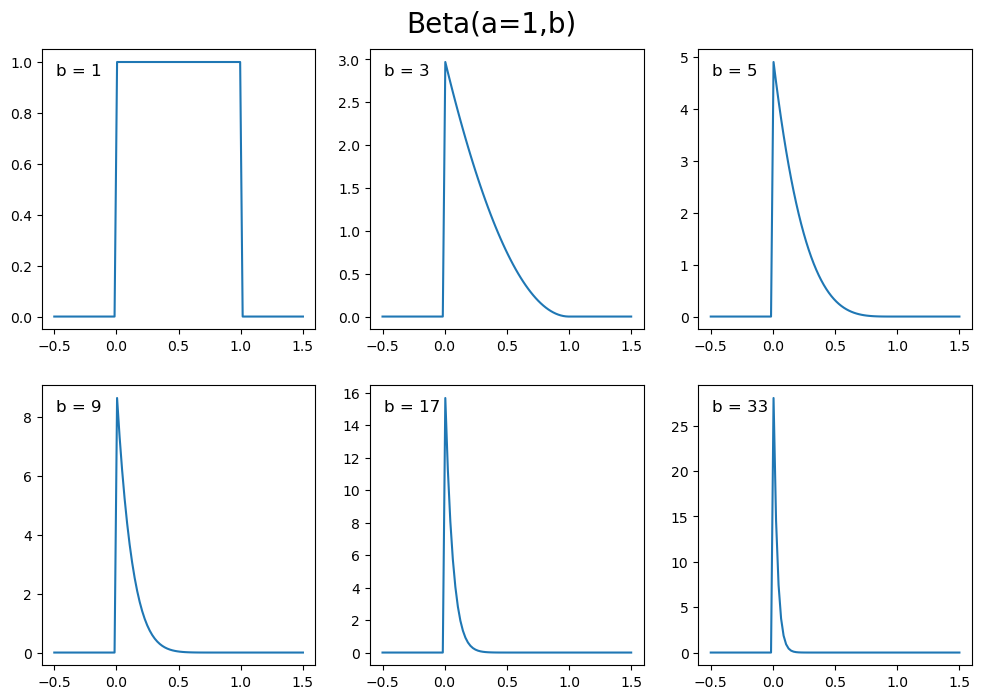

In [30]:
# Critical values of b in Beta distribution given a=1
bs = [1,3,5,9,17,33]
xx = np.linspace(-0.5,1.5,100)

fig, ax = plt.subplots(nrows=2,ncols=3, figsize=(12,8))
fig.suptitle('Beta(a=1,b)', y=0.93, fontsize=20)
ax = ax.flatten()
for i, b in enumerate(bs):
    yy = beta.pdf(xx,a=1,b=b)
    ax[i].plot(xx,yy)
    plt.text(0.05, 0.95, 'b = {}'.format(b),
                 horizontalalignment='left',
                 verticalalignment='top',
                 transform = ax[i].transAxes, fontsize=12)

Since the biggest globular cluster known is Omega Centauri with diameter $ D \simeq 50[pc]$ (VERIFY CLAIM), if the difference in Galactocentric radius $\Delta R_{gc}$ is smaller than, lets say, $D$ of $D/2$, then the clusters are very likely to share gas, so the A value for that pair of clusters should be allowed to be greater than, lest say, 0.5, while the clusters for which $\Delta R_{gc} > 2D$ should be less likely to share gas, then its A value should be smaller than, lest say, 0.2. So for clusters that are close from one another the value of b in the Beta prior distribution for A should b at most $5 (1+4)$, while in the contraty the value of b should be greater than $17 (1 + 16)$. when the clusters are near the same ($R_{gc} \simeq 0 $) then is feasible to share a lot of gas, then $b = 1 + 0$. So I would like to parametrize the $\Delta R_{gc}$ matrix so I can define the prior for A based on the previous assumptions. Maybe choosing $b = 1 + (\Delta R_{gc}/ (D/2) )$ we could achieve such thing.

Note that by doing that we would have that $4.6\%$ of the pairs of clusters (where $\Delta R_{gc} < 2D$ would have a priors allowed to reach values from 0.5 to 1. while the rest (where $\Delta R_{gc} > 2D$ should have smaller values near 0.

0.04734299516908213


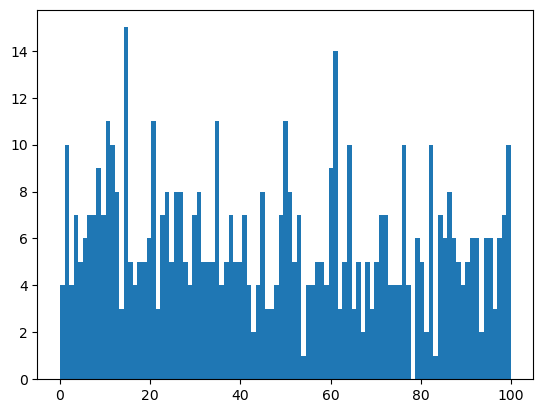

In [31]:
bs = Delta_Rgc[np.triu_indices(K,k=1)]  / (50/4)  
print(np.sum(bs < 8) / len(bs))
plt.hist(bs, bins=np.linspace(0,100,100));

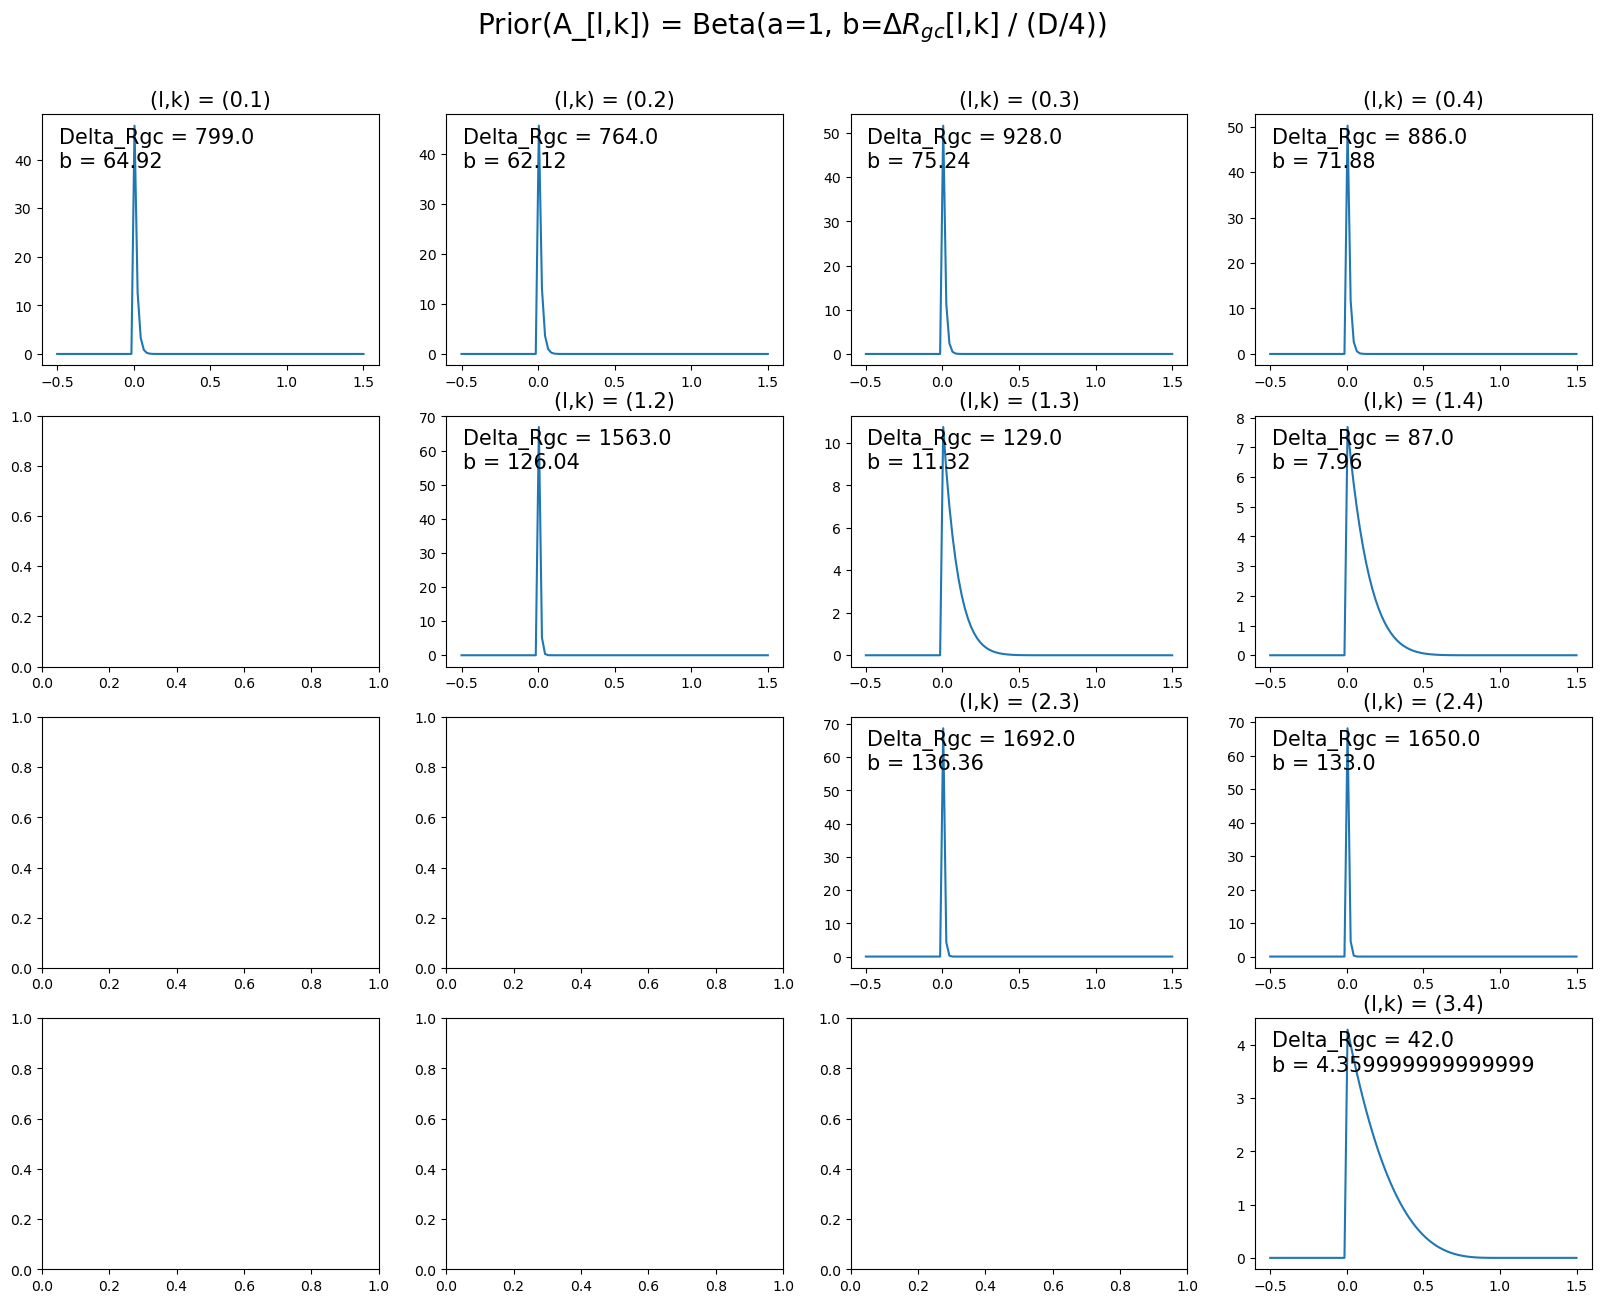

In [32]:
# Prior for first 5 clusters
K_ = 5
xx = np.linspace(-0.5,1.5,100)
fig, ax = plt.subplots(nrows=K_-1, ncols=K_- 1, figsize=(4*K_, 3*K_))
fig.suptitle(r'Prior(A_[l,k]) = Beta(a=1, b=$\Delta R_{gc}$[l,k] / (D/4))', y=0.95, fontsize=20)
for l in range(K_):
    for k in range(l+1,K_):
        b = 1 + Delta_Rgc[l,k] / (50/4)
        yy = beta.pdf(xx,a=1,b=b)
        ax[l,k-1].plot(xx,yy)
        plt.text(0.05, 0.95, 'Delta_Rgc = {}\nb = {}'.format(Delta_Rgc[l,k],b),
                 horizontalalignment='left',
                 verticalalignment='top',
                 transform = ax[l,k-1].transAxes, fontsize=15)
        ax[l,k-1].set_title('(l,k) = ({}.{})'.format(l,k), fontsize=15)

How to do a proper proposal for A

Which value of A_delta choose?

Seems like A_delta = 1.5 gives room to intermediate values of A to be sampled around the same neighbourhood while for values of A around the edges 0,1 are likely to be the same.

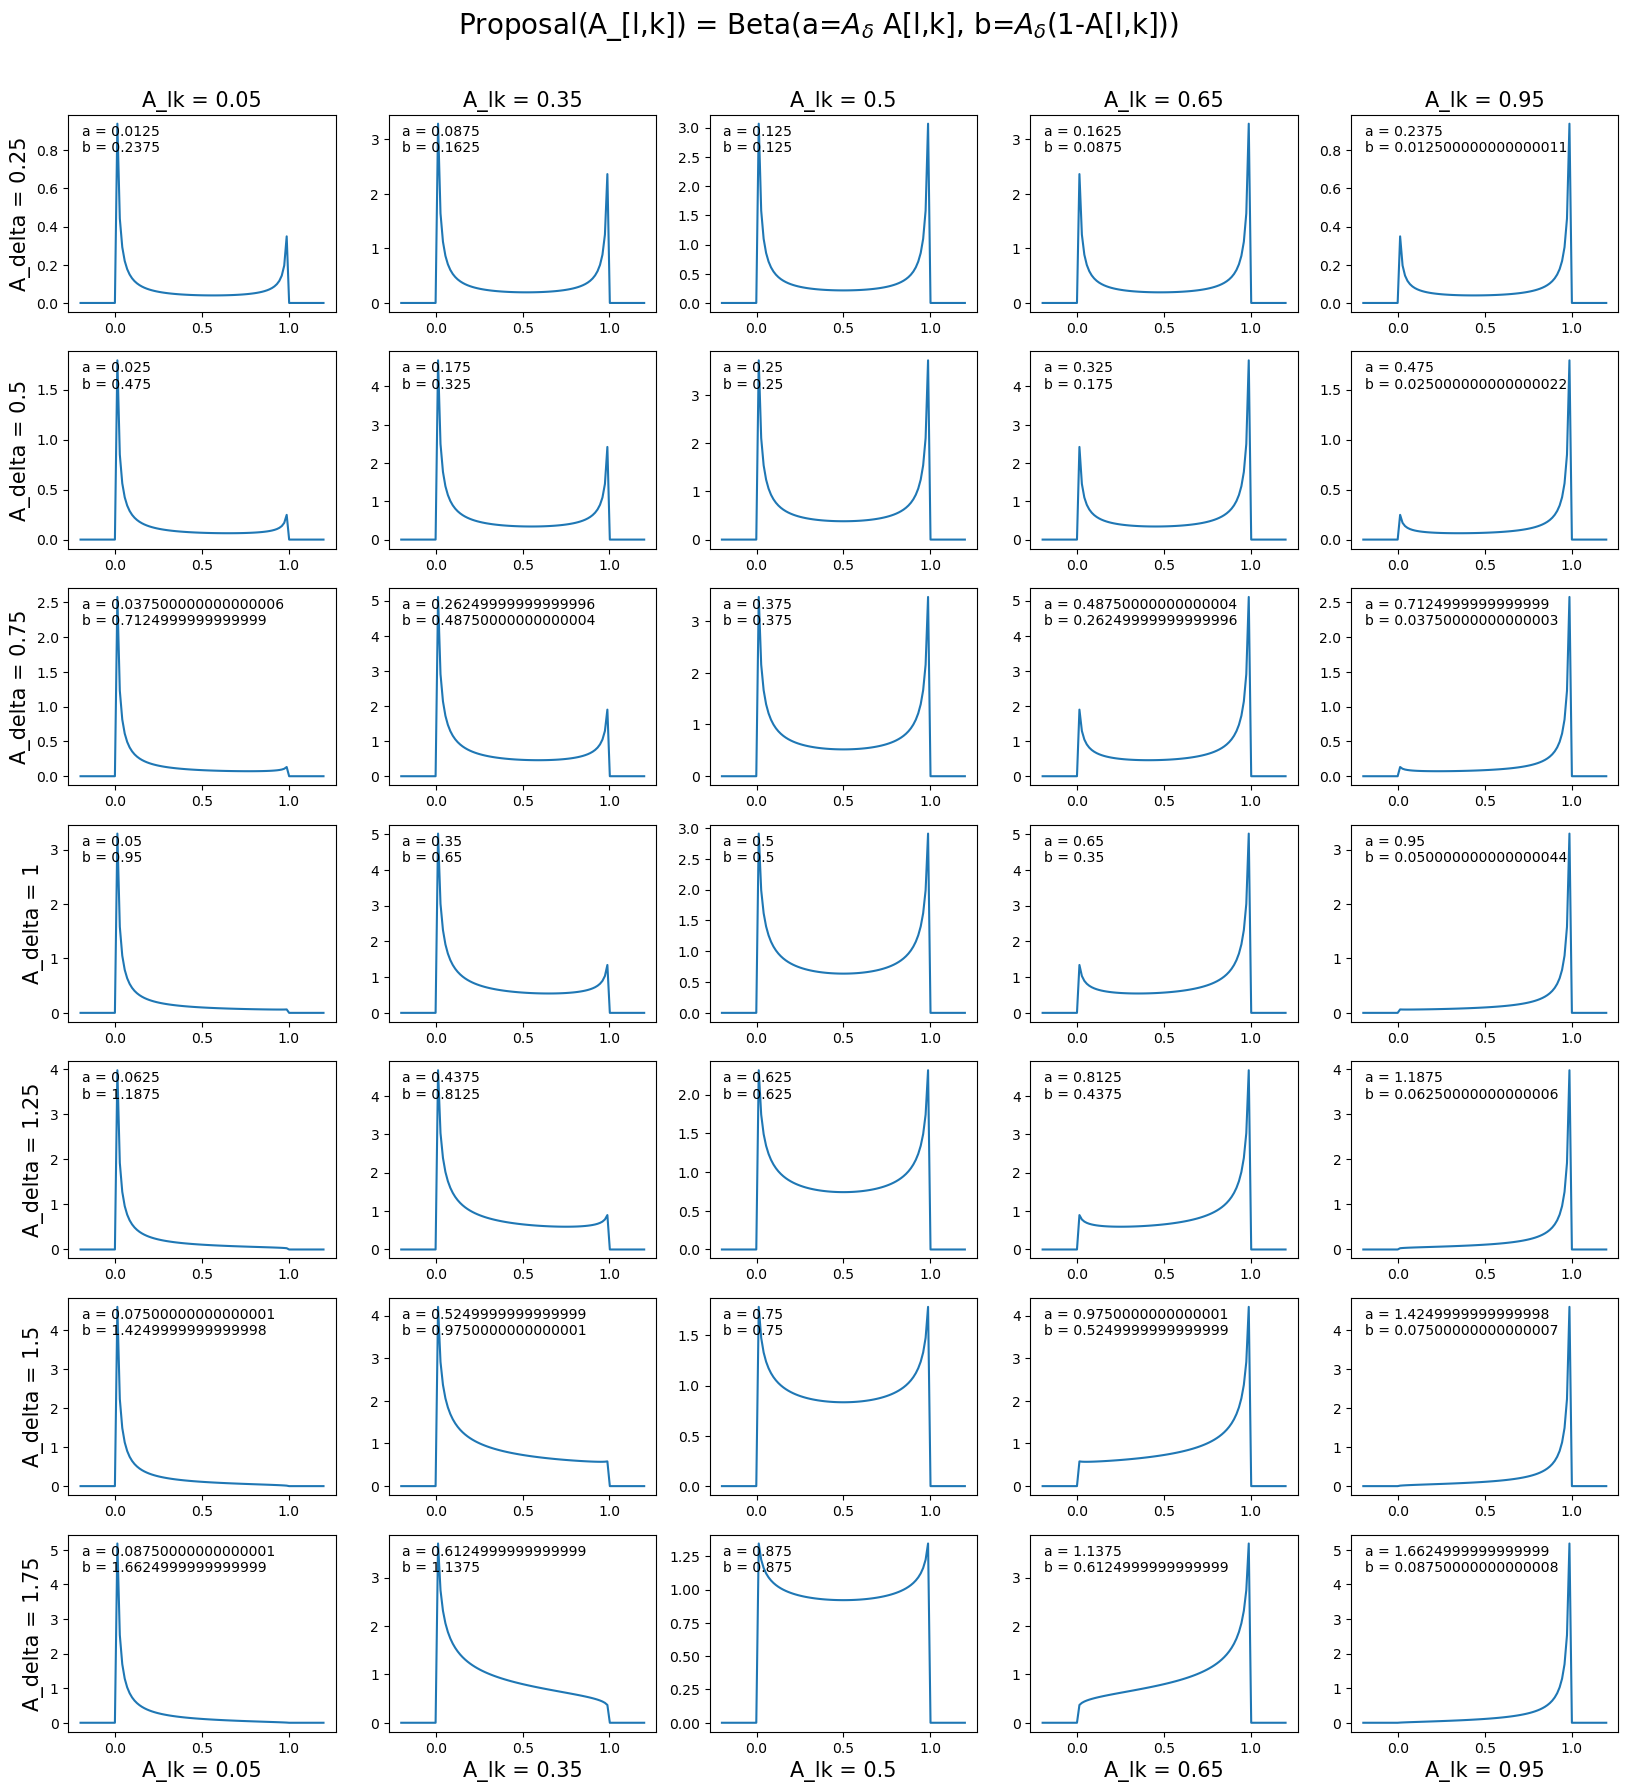

In [33]:
# Which value of A_delta choose?
xx = np.linspace(-0.2,1.2,100)
A_deltas = [0.25,0.5,0.75,1,1.25,1.5,1.75]
A_lks = [0.05,0.35,0.5,0.65,0.95]

fig,ax = plt.subplots(nrows=len(A_deltas), ncols=len(A_lks), figsize=(4*len(A_lks),3*len(A_deltas)))#, sharex=True, sharey=True)
fig.suptitle(r'Proposal(A_[l,k]) = Beta(a=$A_\delta$ A[l,k], b=$A_\delta$(1-A[l,k]))', y=0.93, fontsize=20)
for i, A_delta in enumerate(A_deltas):
    ax[i,0].set_ylabel('A_delta = {}'.format(A_delta), fontsize=15)
for j, A_lk in enumerate(A_lks):
    ax[0,j].set_title('A_lk = {}'.format(A_lk), fontsize=15)
    ax[-1,j].set_xlabel('A_lk = {}'.format(A_lk), fontsize=15)
for i, A_delta in enumerate(A_deltas):
    for j, A_lk in enumerate(A_lks):
        a, b = A_delta*A_lk, A_delta*(1-A_lk)
        yy = beta.pdf(xx,a=a,b=b)
        ax[i,j].plot(xx,yy)
        plt.text(0.05, 0.95, 'a = {}\nb = {}'.format(a,b),
                 horizontalalignment='left',
                 verticalalignment='top',
                 transform = ax[i,j].transAxes, fontsize=10)

# MCMC

In [34]:
def MH(T, T_m, T_sd, G, X, Y_m, Y_sd, A, Delta_Rgc, cluster_idx, T_delta=5e-1, A_delta=15e-1):
    
    # Update each cluster age in T
    for k in range(len(X)):
        try:
            # We compute the current logLik and logPr
            logLik = logLikelihood(T,G,X,Y_m,Y_sd,A) 
            logPr = logPrior(T,T_m,T_sd,A,Delta_Rgc)#,A_m)

            # All the arrays related to cluster order by age
            T_ = copy.deepcopy(T)
            T_m_ = copy.deepcopy(T_m)
            T_sd_ = copy.deepcopy(T_sd)
            G_ = copy.deepcopy(G)
            X_ = copy.deepcopy(X)
            Y_m_ = copy.deepcopy(Y_m)
            Y_sd_ = copy.deepcopy(Y_sd)
            A_ = copy.deepcopy(A)
            #A_m_ = copy.deepcopy(A_m)
            Delta_Rgc_ = copy.deepcopy(Delta_Rgc)
            cluster_idx_ = copy.deepcopy(cluster_idx)
            
            # We change the age in cluster k
            T_[k] = np.abs(T_[k] + (uniform.rvs() - 0.5) * T_delta) # Consider the reflection if value is negative

            cluster_sort_idx = np.argsort(T_)[::-1] # Ages descending
            #if len(np.where(np.arange(len(T_)) != cluster_sort_idx)[0]) > 0: # If the order in ages change
            if np.all(cluster_sort_idx == np.arange(len(T_))): # If the order in ages change
                ## We reorder all the arrays based on new ages
                #
                T_ = T_[cluster_sort_idx]
                T_m_ = T_m_[cluster_sort_idx]
                T_sd_ = T_sd_[cluster_sort_idx]
                G_ = G_[cluster_sort_idx]

                #
                X_ = [X_[l] for l in cluster_sort_idx]

                #
                Y_m_ = Y_m_[cluster_sort_idx,:,:][:,cluster_sort_idx,:]
                for j in range(np.shape(Y_m_)[2]): # To move lower diagonal elements to upper diagonal
                    Y_m_[:,:,j] = np.triu(Y_m_[:,:,j]) + np.transpose(np.tril(Y_m_[:,:,j]))

                #
                Y_sd_ = Y_sd_[cluster_sort_idx,:,:,:][:,cluster_sort_idx,:,:]
                for j1 in range(np.shape(Y_sd_)[2]): # To move lower diagonal elements to upper diagonal
                    for j2 in range(np.shape(Y_sd_)[3]):
                        Y_sd_[:,:,j1,j2] = np.triu(Y_sd_[:,:,j1,j2]) + np.transpose(np.tril(Y_sd_[:,:,j1,j2]))

                A_ = A_[cluster_sort_idx,:][:,cluster_sort_idx]
                A_ = np.triu(A_) + np.transpose(np.tril(A_)) # To move lower diagonal elements to upper diagonal

                #
                #A_m_ = A_m_[cluster_sort_idx,:][:,cluster_sort_idx] # Here we just have to reorder rows and columns
                
                Delta_Rgc_ = Delta_Rgc_[cluster_sort_idx,:][:,cluster_sort_idx] # Here we just have to reorder rows and columns
                cluster_idx_ = cluster_idx_[cluster_sort_idx]
                
                # We compute the new logLik and logPr
                logLik_ = logLikelihood(T_,G_,X_,Y_m_,Y_sd_,A_) 
                logPr_ = logPrior(T_,T_m_,T_sd_,A_,Delta_Rgc_)#,A_m_)

                # We compute the acceptance probability
                a = np.min([1, np.exp((logPr_ - logPr) + (logLik_ - logLik))])
                v = uniform.rvs()
                if v <= a:
                    #print('Update in T[{}]'.format(k), T[k], T_[k])
                    #print('Change in logLik: {}'.format(logLik_ - logLik))
                    #print('Change in logPr: {}'.format(logPr_ - logPr))
                    T = T_
                    T_m = T_m_
                    T_sd = T_sd_
                    G = G_
                    X = X_
                    Y_m = Y_m_
                    Y_sd = Y_sd_
                    A = A_
                    #A_m = A_m_
                    Delta_Rgc = Delta_Rgc_
                    cluster_idx = cluster_idx_
        except:
            print('MCMC failed for k={}'.format(k), T[k])
                
    # Update each element in the upper diagonal of A
    for l in range(len(X)):
        for k in range(l+1,len(X)):
            try:
                # We compute the current logLik and logPr
                logLik = logLikelihood(T,G,X,Y_m,Y_sd,A) 
                logPr = logPrior(T,T_m,T_sd,A,Delta_Rgc)#,A_m)

                # We change A
                A_ = copy.deepcopy(A)
                #A_[l,k] = np.abs(A[l,k] + (uniform.rvs() - 0.5) * A_delta)
                A_[l,k] = beta.rvs(a=A_delta*A[l,k], b=A_delta*(1-A[l,k]))
                
                # We compute the new logLik and logPr
                logLik_ = logLikelihood(T,G,X,Y_m,Y_sd,A_) 
                logPr_ = logPrior(T,T_m,T_sd,A_,Delta_Rgc)#,A_m)

                # We compute the acceptance probability
                a = np.min([1, np.exp((logPr_ - logPr) + (logLik_ - logLik))])
                v = uniform.rvs()
                if v <= a:
                    #print('Update in A[{},{}]'.format(l,k), A[l,k], A_[l,k])
                    #print('Change in logLik: {}'.format(logLik_ - logLik))
                    #print('Change in logPr: {}'.format(logPr_ - logPr))
                    A = A_
            except ValueError:
                print('MCMC failed for (l,k)=({},{})'.format(l,k), A[l,k])
                
    # Update bin index of gas mass of each cluster in G
    for l in range(len(X)):
        try:
            # We compute the current logLik
            logLik = logLikelihood(T,G,X,Y_m,Y_sd,A)

            # We change G
            G_ = copy.deepcopy(G)
            #k = randint.rvs(low=l+1, high=len(X)) #
            k = np.random.choice(np.arange(len(X))[np.arange(len(X))!=l]) # Sample a random index except the current
            G_[l], G_[k] = G_[k], G_[l] # Swap bin index is the same as swapping the values of G between the clusters

            # We compute the new logLik
            logLik_ = logLikelihood(T,G_,X,Y_m,Y_sd,A) 

            # We compute the acceptance probability
            a = np.min([1, np.exp(logLik_ - logLik)])
            v = uniform.rvs()
            if v <= a:
                #print('Update in G[{}]'.format(l))
                #print('Change in logPr: {}'.format(logPr_ - logPr))
                G = G_
        except:
            print('MCMC failed for (l,k)=({},{})'.format(l,k), A[l,k])
             
    # We compute the final logLik and logPr
    logLik = logLikelihood(T,G,X,Y_m,Y_sd,A) 
    logPr = logPrior(T,T_m,T_sd,A)#,A_m)
    
    return T, T_m, T_sd, G, X, Y_m, Y_sd, A, Delta_Rgc, cluster_idx, logLik, logPr#, A_m

In [35]:
def MCMC(T, T_m, T_sd, G, X, Y_m, Y_sd, A, Delta_Rgc, cluster_idx, n_iterations=1000):
    '''
    Initial:
    T, T_m, T_sd, G, X, Y_m, Y_sd, A, A_m
    '''
    K, J = np.shape(Y_m)[1:] # Clusters, Species
    
    # We define the chains
    T_chain = np.zeros((n_iterations+1,K))
    #T_m_chain = np.zeros((n_iterations,K))
    #T_sd_chain = np.zeros((n_iterations,K))
    G_chain = np.zeros((n_iterations+1,K))
    #X_chain = [] # list of lists
    #Y_m_chain = np.zeros((n_iterations,K,K,J))
    #Y_sd_chain = np.zeros((n_iterations,K,K,J,J))
    A_chain = np.zeros((n_iterations+1,K,K))
    ##A_m_chain = np.zeros((n_iterations,K,K))
    Delta_Rgc_chain = np.zeros((n_iterations,K,K))
    cluster_idx_chain = np.zeros((n_iterations,K))
    logLik_chain = np.zeros(n_iterations+1)
    logPr_chain = np.zeros(n_iterations+1)
    
    T_chain[0] = T
    G_chain[0] = G
    A_chain[0] = A
    Delta_Rgc_chain[0] = Delta_Rgc
    cluster_idx_chain[0] = cluster_idx
    logLik_chain[0] = logLikelihood(T,G,X,Y_m,Y_sd,A) 
    logPr_chain[0] = logPrior(T,T_m,T_sd,A,Delta_Rgc) 
    
    # Iterate the MCMC
    for i in range(1,n_iterations+1):
        print('Iteration {}/{}'.format(i,n_iterations))
        # One iteration of Metropolist Hastings
        T, T_m, T_sd, G, X, Y_m, Y_sd, A, Delta_Rgc, cluster_idx, logLik, logPr = MH(T, T_m, T_sd, G, X, Y_m, Y_sd, A, Delta_Rgc, cluster_idx)#, A_m)
        
        # Update the chains
        T_chain[i] = copy.deepcopy(T) # Not sure of duck-typing if I dont use copy
        #T_m_chain[i] = T_m # Doesn't change besides rearrange
        #T_sd_chain[i] = T_sd # Doesn't change besides rearrange
        G_chain[i] = copy.deepcopy(G) # Not sure of duck-typing if I dont use copy
        #X_chain.append(X) # Doesn't change besides rearrange
        #Y_m_chain[i] = Y_m # Doesn't change besides rearrange + transpose lower diagonal
        #Y_sd_chain[i] = Y_sd # Doesn't change besides rearrange + transpose lower diagonal
        A_chain[i] = copy.deepcopy(A) # Not sure of duck-typing if I dont use copy
        ##A_m_chain[i] = A_m # Doesn't change besides rearrange
        Delta_Rgc_chain[i] = copy.deepcopy(Delta_Rgc)
        cluster_idx_chain[i] = copy.deepcopy(cluster_idx)
        logLik_chain[i] = logLik
        logPr_chain[i] = logPr

    # We save the updates after iterating
    np.save('mcmc/iter{}/T_chain.npy'.format(n_iterations), T_chain)
    np.save('mcmc/iter{}/G_chain.npy'.format(n_iterations), G_chain)
    np.save('mcmc/iter{}/A_chain.npy'.format(n_iterations), A_chain)
    np.save('mcmc/iter{}/Delta_Rgc_chain.npy'.format(n_iterations), Delta_Rgc_chain)
    np.save('mcmc/iter{}/cluster_idx_chain.npy'.format(n_iterations), cluster_idx_chain)
    np.save('mcmc/iter{}/logLik_chain.npy'.format(n_iterations), logLik_chain)
    np.save('mcmc/iter{}/logPr_chain.npy'.format(n_iterations), logPr_chain)
    

In [658]:
# 80 iterations: 8h17m22s
#MCMC(T, T_m, T_sd, G, X, Y_m, Y_sd, A, n_iterations=10)

Iteration 1/80


/tmp/ipykernel_29844/2939771982.py:96: RuntimeWarning: overflow encountered in exp
  a = np.min([1, np.exp((logPr_ - logPr) + (logLik_ - logLik))])
/tmp/ipykernel_29844/2939771982.py:122: RuntimeWarning: overflow encountered in exp
  a = np.min([1, np.exp(logLik_ - logLik)])


Iteration 2/80
Iteration 3/80
Iteration 4/80
Iteration 5/80
Iteration 6/80
Iteration 7/80
Iteration 8/80
Iteration 9/80
Iteration 10/80
Iteration 11/80
Iteration 12/80
Iteration 13/80
Iteration 14/80
Iteration 15/80
Iteration 16/80
Iteration 17/80
Iteration 18/80
Iteration 19/80
Iteration 20/80
Iteration 21/80
Iteration 22/80
Iteration 23/80
Iteration 24/80
Iteration 25/80
Iteration 26/80
Iteration 27/80
Iteration 28/80
Iteration 29/80
Iteration 30/80
Iteration 31/80
Iteration 32/80
Iteration 33/80
Iteration 34/80
Iteration 35/80
Iteration 36/80
Iteration 37/80
Iteration 38/80
Iteration 39/80
Iteration 40/80
Iteration 41/80
Iteration 42/80
Iteration 43/80
Iteration 44/80
Iteration 45/80
Iteration 46/80
Iteration 47/80
Iteration 48/80
Iteration 49/80
Iteration 50/80
Iteration 51/80
Iteration 52/80
Iteration 53/80
Iteration 54/80
Iteration 55/80
Iteration 56/80
Iteration 57/80
Iteration 58/80
Iteration 59/80
Iteration 60/80
Iteration 61/80
Iteration 62/80
Iteration 63/80
Iteration 64/80


- Find a more efficient way to save arrays so I don't use much memory
- One iteration took 6m20s, then for 1000 iterations it may take around 4.4 days
- The changes in logLik are predominant over logPr (10^7 over 10^3) (MAYBE OUTDATED)

In [36]:
# 80 iterations (OUTDATED)
T_chain = np.load('mcmc/iter80/T_chain.npy')
A_chain = np.load('mcmc/iter80/A_chain.npy')
G_chain = np.load('mcmc/iter80/G_chain.npy')
logLik_chain = np.load('mcmc/iter80/logLik_chain.npy')
logPr_chain = np.load('mcmc/iter80/logPr_chain.npy')

In [37]:
print(logLik_chain)
print(logPr_chain)

[-2.30995680e+19 -1.23006990e+12 -2.39883040e+11 -8.56983562e+10
 -6.86919434e+10 -5.79109292e+10 -4.22580259e+10 -3.58550256e+10
 -3.43473402e+10 -2.96243377e+10 -2.51648080e+10 -2.47770108e+10
 -2.29749035e+10 -2.24984451e+10 -2.21014467e+10 -1.73694541e+10
 -1.65197019e+10 -1.62094079e+10 -1.58904120e+10 -1.56678554e+10
 -1.55616048e+10 -1.53850493e+10 -1.52378904e+10 -1.50722684e+10
 -1.49020187e+10 -1.46152049e+10 -1.45571893e+10 -1.44966908e+10
 -1.44432919e+10 -1.41500194e+10 -1.36401179e+10 -1.31541682e+10
 -1.30165971e+10 -1.29575237e+10 -1.28066129e+10 -1.20512808e+10
 -1.19873579e+10 -1.19596858e+10 -1.19444212e+10 -1.16642077e+10
 -1.15173391e+10 -1.11943612e+10 -1.11499684e+10 -1.02983383e+10
 -1.02832759e+10 -1.02641792e+10 -1.01902001e+10 -1.01197942e+10
 -1.00812670e+10 -1.00509628e+10 -9.97408711e+09 -9.94317306e+09
 -9.88440548e+09 -9.83329674e+09 -9.78140167e+09 -9.76076997e+09
 -9.74776838e+09 -9.67909716e+09 -9.54412276e+09 -9.46727046e+09
 -9.39992033e+09 -9.38549

In [38]:
for i in range(80):
    A__ = A_chain[i]
    print(np.min(A__[A__>0]), np.max(A__))

1.7920518281593185e-07 0.004183969990835203
2.032013412032344e-07 0.028886718196327148
2.032013412032344e-07 0.0468851748991935
2.032013412032344e-07 0.06279509784072262
2.032013412032344e-07 0.07003191620736782
2.032013412032344e-07 0.0826925910619378
2.032013412032344e-07 0.08401407148589976
2.032013412032344e-07 0.08401407148589976
2.032013412032344e-07 0.08401407148589976
2.032013412032344e-07 0.08401407148589976
2.032013412032344e-07 0.10359387600587026
2.032013412032344e-07 0.10359387600587026
2.032013412032344e-07 0.10617511366620051
2.032013412032344e-07 0.12341520646888508
2.032013412032344e-07 0.12341520646888508
2.032013412032344e-07 0.12341520646888508
2.032013412032344e-07 0.12654387802590228
2.032013412032344e-07 0.1327974159842814
2.032013412032344e-07 0.1327974159842814
2.032013412032344e-07 0.1327974159842814
2.032013412032344e-07 0.13142158975490284
2.032013412032344e-07 0.14143007223503784
2.032013412032344e-07 0.14143007223503784
2.032013412032344e-07 0.141430072235

# Visualization

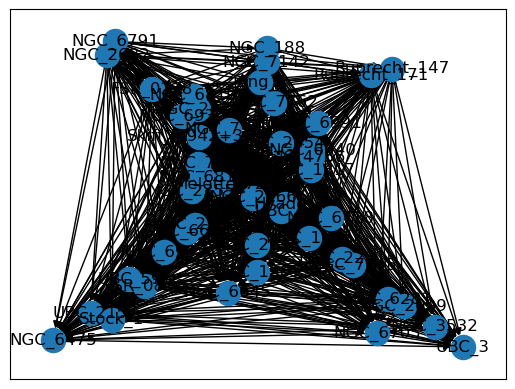

In [39]:
# Using prior for A (46 clusters)
# Computation time: ~1m18s 
g = nx.DiGraph()
g.add_node(clusters[0])

for k in range(1,len(clusters)):
    g.add_node(clusters[k])
    for l in range(k):
        g.add_edge(clusters[l], clusters[k], weight = A[l,k])

nodes = g.nodes()
pos = graphviz_layout(g, prog='dot')

ec = nx.draw_networkx_edges(g, pos)
nc = nx.draw_networkx_nodes(g, pos, nodelist=nodes)
labels = nx.draw_networkx_labels(g,pos)

In [40]:
print(np.min(A[A>0]), np.max(A))
print(np.percentile(A[A>0], 50))
print(np.percentile(A[A>0], 75))
print(np.percentile(A[A>0], 98))

1.8441693792383293e-07 0.004002013436186032
1.4286538449792171e-06
2.840955138355489e-06
5.49262297915892e-05


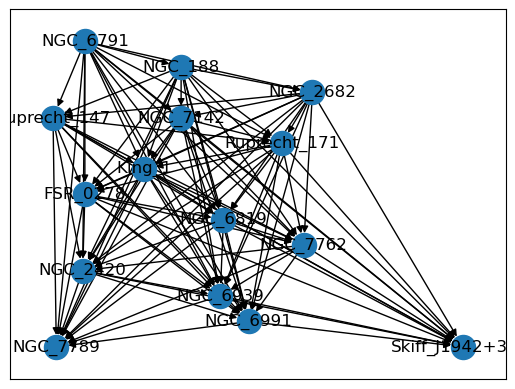

In [41]:
# Using prior for A (first 15 clusters)
# Adding minimum weight to draw edge between nodes (percentile 98)
# Computation time: ~400ms
g = nx.DiGraph()
g.add_node(clusters[0], age=T[0])

for k in range(1,len(clusters[:15])):
    g.add_node(clusters[k], age=T[k])
    for l in range(k):
        if A[l,k] > 1e-7:
            g.add_edge(clusters[l], clusters[k], weight = A[l,k])

nodes = g.nodes()
pos = graphviz_layout(g, prog='dot')

ec = nx.draw_networkx_edges(g, pos)
nc = nx.draw_networkx_nodes(g, pos, nodelist=nodes)
labels = nx.draw_networkx_labels(g,pos)
plt.show()

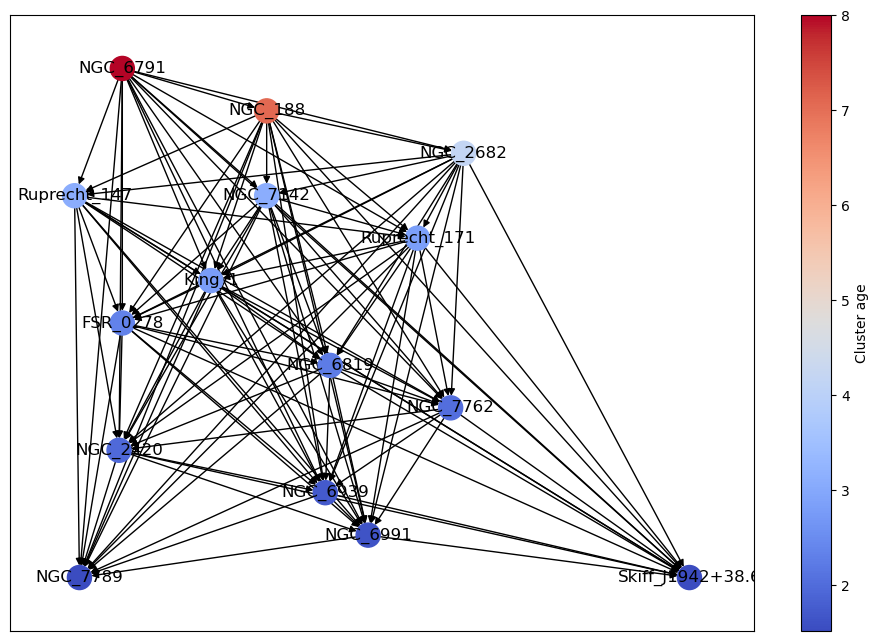

In [42]:
# Using prior for A (first 15 clusters)
# Adding minimum weight to draw edge between nodes (percentile 98)
# Adding colormap with node age
# Computation time: ~500ms
g = nx.DiGraph()
g.add_node(clusters[0], age=T[0])

for k in range(1,len(clusters[:15])):
    g.add_node(clusters[k], age=T[k])
    for l in range(k):
        if A[l,k] > 1e-7:
            g.add_edge(clusters[l], clusters[k], weight = A[l,k])

nodes = g.nodes()
weights = np.array([g.edges()[edge]['weight'] for edge in g.edges()])
pos = graphviz_layout(g, prog='dot')

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(12,8))
ec = nx.draw_networkx_edges(g, pos, ax=ax)
nc = nx.draw_networkx_nodes(g, pos, nodelist=nodes, node_color=T[:15], cmap=plt.cm.coolwarm, ax=ax)
labels = nx.draw_networkx_labels(g,pos, ax=ax)
fig.colorbar(nc, label='Cluster age', ax=ax)
plt.show()

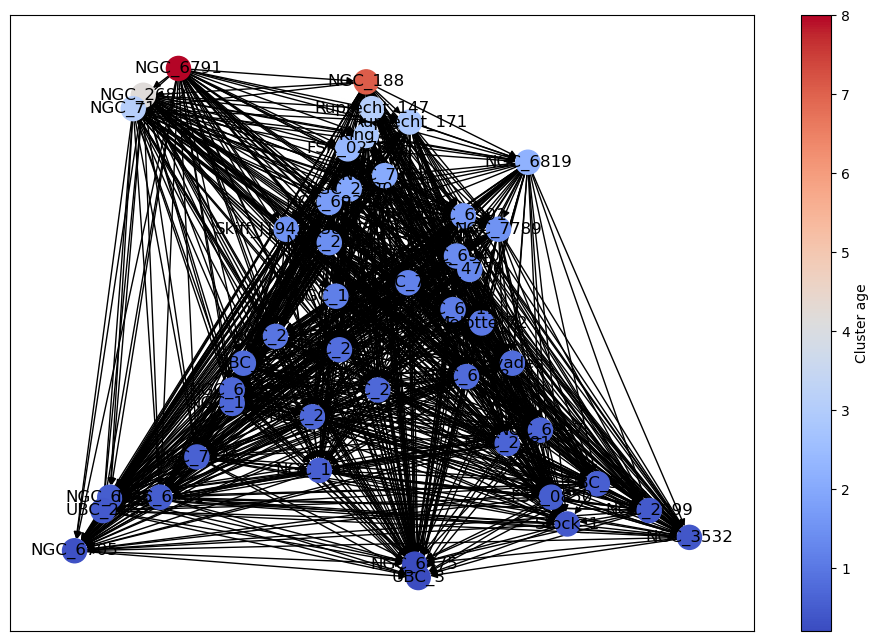

In [43]:
# Using prior for A (46 clusters)
# Adding minimum weight to draw edge between nodes (percentile 75)
# Adding colormap with node age
# Computation time: ~3s 
g = nx.DiGraph()
g.add_node(clusters[0])

for k in range(1,len(clusters)):
    g.add_node(clusters[k])
    for l in range(k):
        if A[l,k] > 1e-9:
            g.add_edge(clusters[l], clusters[k], weight = A[l,k])

nodes = g.nodes()
weights = np.array([g.edges()[edge]['weight'] for edge in g.edges()])
pos = graphviz_layout(g, prog='dot')

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(12,8))
ec = nx.draw_networkx_edges(g, pos, ax=ax)
nc = nx.draw_networkx_nodes(g, pos, nodelist=nodes, node_color=T, cmap=plt.cm.coolwarm, ax=ax)
labels = nx.draw_networkx_labels(g,pos, ax=ax)
fig.colorbar(nc, label='Cluster age', ax=ax)
plt.show()

In [44]:
# 14 clusters with 6+ observed stars
clusters_ = []
clusters_idx_ = []
X_ = []
for k in range(len(X)):
    if len(X[k]) > 5:
        clusters_.append(clusters[k])
        clusters_idx_.append(k)
        X_.append(X[k])
clusters_ = np.array(clusters_)
cluters_idx_ = np.array(clusters_idx_)

n_iterations = 80
A_chain_ = np.array([A_chain[i][clusters_idx_,:][:,clusters_idx_] for i in range(n_iterations)])
T_chain_ = np.array([T_chain[i][clusters_idx_] for i in range(n_iterations)])
A__ = A_chain_[0]
T__ = T_chain[0]

In [45]:
np.min(A__[A__>0]), np.max(A__)

(1.7920518281593185e-07, 4.7808591075932245e-05)

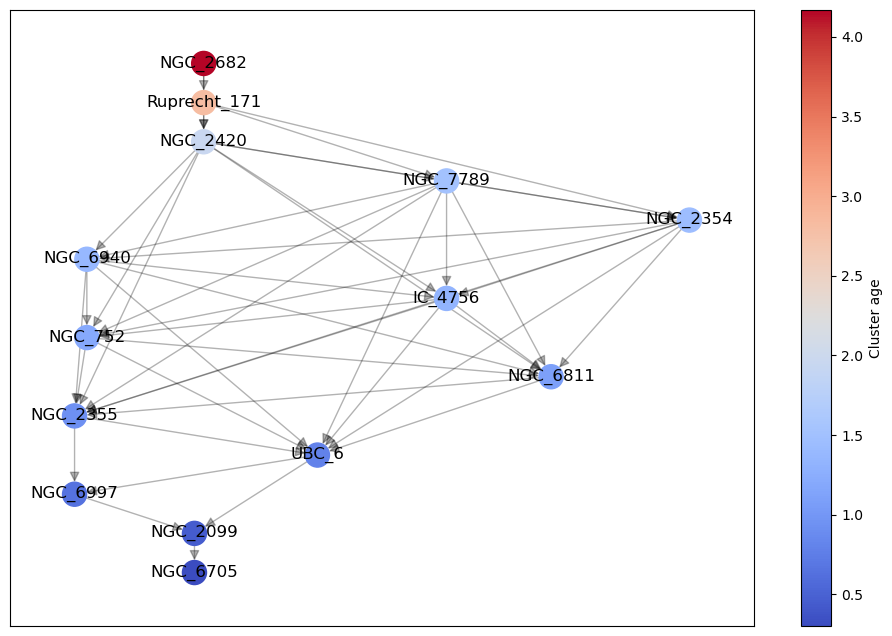

In [46]:
# To overplot I need the nodes to remain in the same position always
# What to do if due to mcmc the age order changes
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(12,8))
n_iterations = 80
for i in range(1):
    A__ = A_chain_[i]
    T__ = T_chain_[i]
    g = nx.DiGraph()
    g.add_node(clusters_[0])

    for k in range(1,len(clusters_)):
        g.add_node(clusters_[k])
        for l in range(k):
            if A__[l,k] > np.percentile(A__[A__>0],50):
                g.add_edge(clusters_[l], clusters_[k], weight = A__[l,k])

    nodes = g.nodes()
    pos = graphviz_layout(g, prog='dot')

    ec = nx.draw_networkx_edges(g, pos, ax=ax, alpha=0.3, arrowsize=15)
    nc = nx.draw_networkx_nodes(g, pos, nodelist=nodes, node_color=T__, cmap=plt.cm.coolwarm, ax=ax)#, node_size=200)
    labels = nx.draw_networkx_labels(g,pos, ax=ax)
fig.colorbar(nc, label='Cluster age', ax=ax)
#plt.savefig('mcmc/imgs/network.pdf', format='pdf')
#plt.savefig('mcmc/imgs/network.jpg', format='jpg')
plt.show()

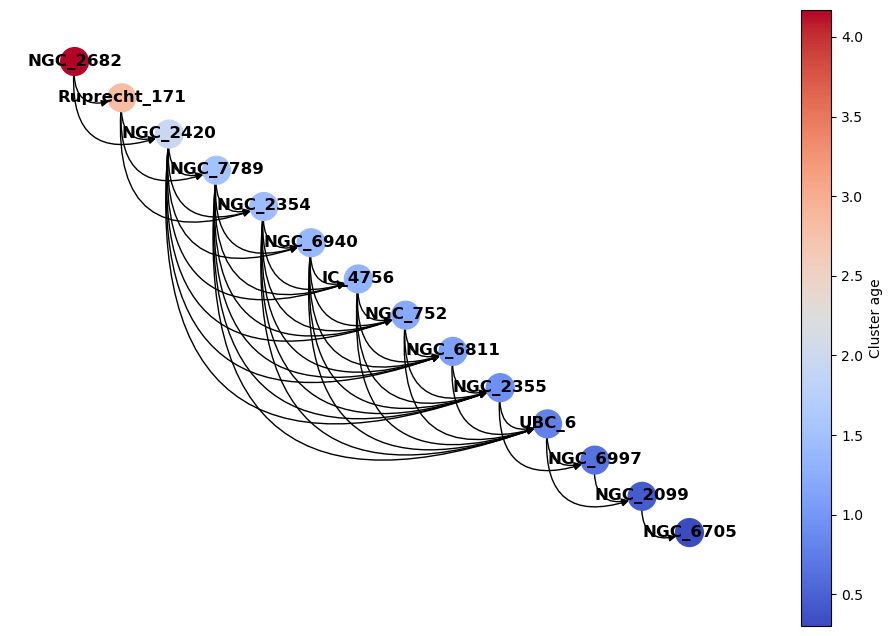

In [49]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(12,8))

for i in range(1):
    A__ = A_chain_[i]
    T__ = T_chain_[i]
    g = nx.DiGraph()
    g.add_node(clusters_[0])

    for k in range(1,len(clusters_)):
        g.add_node(clusters_[k])
        for l in range(k):
            if A__[l,k] > np.percentile(A__[A__>0],50):
                g.add_edge(clusters_[l], clusters_[k], weight = A__[l,k])

    T_scaled = (np.max(T__) - T__) / (np.max(T__) - np.min(T__)) # MaxMinScaled for plotting
    #nodePosDict = {cluster: [T_scaled[k], ((len(clusters_)-1)-k)/(len(clusters_)-1)] for k,cluster in enumerate(clusters_) }
    nodePosDict = {cluster: [k/(len(clusters_)-1), ((len(clusters_)-1)-k)/(len(clusters_)-1)] for k,cluster in enumerate(clusters_)}
    #labelPosDict = {cluster: [((len(clusters_)-1)-k)/(len(clusters_)-1), k/(len(clusters_)-1)] for k,cluster in enumerate(clusters_)}
    nx.draw(g,with_labels=True, pos=nodePosDict, node_color=T__, cmap=plt.cm.coolwarm, ax=ax,
            node_size=400, alpha=1, font_weight="bold", arrows=True,
           connectionstyle='arc3, rad = 0.8')

    nc = nx.draw_networkx_nodes(g, pos=nodePosDict, nodelist=nodes, node_color=T__, cmap=plt.cm.coolwarm, ax=ax)#, node_size=200)
fig.colorbar(nc, label='Cluster age', ax=ax)
plt.show()

In [50]:
nodePosDict

{'NGC_2682': [0.0, 1.0],
 'Ruprecht_171': [0.07692307692307693, 0.9230769230769231],
 'NGC_2420': [0.15384615384615385, 0.8461538461538461],
 'NGC_7789': [0.23076923076923078, 0.7692307692307693],
 'NGC_2354': [0.3076923076923077, 0.6923076923076923],
 'NGC_6940': [0.38461538461538464, 0.6153846153846154],
 'IC_4756': [0.46153846153846156, 0.5384615384615384],
 'NGC_752': [0.5384615384615384, 0.46153846153846156],
 'NGC_6811': [0.6153846153846154, 0.38461538461538464],
 'NGC_2355': [0.6923076923076923, 0.3076923076923077],
 'UBC_6': [0.7692307692307693, 0.23076923076923078],
 'NGC_6997': [0.8461538461538461, 0.15384615384615385],
 'NGC_2099': [0.9230769230769231, 0.07692307692307693],
 'NGC_6705': [1.0, 0.0]}